# Propensity to fund mortgages: refined models

Author: Yoann Pradat

Competition hosted on crowdanalytix.com. It aims at predicting whether a mortgage will be funded or not based on applicant's data. It is therefore a binary classification problem.

In [2]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
import pandas as pd

import os
import sys

import itertools
import time
import warnings

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
class Ignore(BaseEstimator, TransformerMixin):
    def __init__(self, cols_ignore):
        self.cols_ignore=cols_ignore
    def fit(self, X, y):
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_ignore:
            del Xc[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Preprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, cols_num, eps=1e-1):
        self.cols_num=cols_num
        self.esp = eps
    def fit(self, X, y):
        self.tds_upper = X.tds.quantile(0.99)
        self.gds_upper = X.gds.quantile(0.99)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        # Indicator of extreme values
        Xc.loc[:, 'tds_le_0'] = np.where(Xc.tds <= 0, 1, 0)
        Xc.loc[:, 'ltv_gt_80'] = np.where(Xc.ltv > 80, 1, 0)
        # Clip too extreme values of tds and tmgds
        Xc.loc[:, 'tds'] = Xc.tds.clip(lower=0, upper=self.tds_upper)
        Xc.loc[:, 'gds'] = Xc.gds.clip(lower=0, upper=self.gds_upper)
        # Log transform
        eps = 1e-1
        for x in self.cols_num:
            Xc.loc[:, x] = np.log10(Xc[x] + eps)
        # As gds and tds are very correlated (0.99) we will only keep tds and add feature tds - gds
        Xc.loc[:, 'tmgds'] = Xc.loc[:, 'tds'] - Xc.loc[:, 'gds']
        del Xc['gds']
        return Xc  

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, center=True, norm_ord=2):
        self.center=center
        self.norm_ord=norm_ord
    def fit(self, X, y):
        n, _ = X.shape
        self.centers = {}
        self.norms = {}
        for x in X:
            if X[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                center = np.mean(X[x])
                norm = np.linalg.norm(X[x]-center)
                self.centers[x] = center
                self.norms[x] = norm/np.sqrt(n)
            else:
                norm = np.linalg.norm(X[x]-center, ord=norm_ord)
                self.norms[x] = norm/np.sqrt(n)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in Xc:
            if Xc[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                Xc.loc[:, x] = (Xc[x]-self.centers[x])/self.norms[x]
            else:
                Xc.loc[:, x] = Xc[x]/self.norms[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_onehot, categories, other_lim=0.02):
        self.cols_onehot = cols_onehot
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.category_other = {}
        for x, category in zip(self.cols_onehot, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_onehot:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        self.onehotenc = OneHotEncoder(categories=self.categories)
        self.onehotenc.fit(Xc[self.cols_onehot])
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_onehot:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        Xdummy = self.onehotenc.transform(Xc[self.cols_onehot])
        Xdummy = Xdummy.toarray()
        cols_Xdummy = ['']*Xdummy.shape[1]
        offset = 0
        for x, category in zip(self.cols_onehot, self.categories):
            for i, cat in enumerate(category):
                cols_Xdummy[offset + i] = '%s_%s' % (x, str(cat))
            offset += len(category)
            del Xc[x]
        Xdummy = pd.DataFrame(Xdummy, columns=cols_Xdummy).astype(int)
        Xdummy.index = index=Xc.index
        for x, category in zip(self.cols_onehot, self.categories):
            del Xdummy['%s_%s' % (x, str(category[0]))]
        Xc = pd.concat((Xc, Xdummy), axis=1)
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class LabEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat):
        self.cols_cat = cols_cat
    def fit(self, X, y):
        n, _ = X.shape
        self.encoders = {}
        for x in self.cols_cat:
            encoder = LabelEncoder()
            encoder.fit(X[x])
            self.encoders[x] = encoder
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_cat:
            Xc.loc[:, x] = self.encoders[x].transform(Xc[x])
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
def plot_learning_curve(param_grid, best_params, cv_results, params_logscale=None):
    best_params_plot = {}
    for param_n, param_v in param_grid.items():
        if len(param_v) > 1:
            best_params_plot[param_n] = best_params[param_n]           
    ncols = 2
    nrows = np.int(np.ceil(len(best_params_plot)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
    ax = ax.flatten()
    
    for i, (param_n, param_v) in enumerate(best_params_plot.items()):
        best_idx = []
        for idx, params  in enumerate(cv_results['params']):
            if all([params[x] == best_params[x] for x in best_params.keys() if x!=param_n]):
                best_idx.append(idx)
                
        param_values = np.array([cv_results['params'][idx][param_n] for idx in best_idx])
        train_scores_mean = np.array([cv_results['mean_train_score'][idx] for idx in best_idx])
        train_scores_std = np.array([cv_results['std_train_score'][idx] for idx in best_idx])
        test_scores_mean = np.array([cv_results['mean_test_score'][idx] for idx in best_idx])
        test_scores_std = np.array([cv_results['std_test_score'][idx] for idx in best_idx])
        
        ax[i].grid()
        ax[i].fill_between(param_values, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax[i].fill_between(param_values, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax[i].plot(param_values, train_scores_mean, 'o-', color="r", label="Training score")
        ax[i].plot(param_values, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[i].set_title('Learning curve for %s' % param_n, fontsize=18, fontweight='bold')
        if param_n in params_logscale:
            ax[i].set_xscale('log')
        ax[i].legend(loc="best")
    if i < 2*nrows-1:
        ax[-1].axis('off')
    plt.show(fig)
    
# Function useful to compare coefficients
# Default parameters are for comparison across the 5 splits

def plot_compare_coeffs(list_coeffs, title, list_positions = [-3.5, -1.5, 0, 1.5, 3.5], 
                        list_colors = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_ecolors = ['lightsalmon', 'palegreen', 'lightgray', 'lightskyblue', 'palegoldenrod'], 
                        list_els=['-', '-', '-', '-', '-'], 
                        list_colors_labels = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_labels = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5'], 
                        list_lgd_ls=None, 
                        list_lgd_ls_labels=None, 
                        list_format=['o', 'o', 'o', 'o', 'o']): 
    
    n_coeffs = list_coeffs[0].shape[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))

    for i, col, ecol, coeffs, els, fmt in zip(list_positions, list_colors, list_ecolors, list_coeffs, list_els, list_format):
        eb = ax.errorbar(x=np.arange(n_coeffs) + i / 10, 
                         y=coeffs.values, 
                         yerr=[coeffs.values, np.zeros(n_coeffs)],
                        fmt=fmt, color=col, ecolor=ecol, elinewidth=3, capsize=0)
        eb[-1][0].set_linestyle(els)

    ax.set_xticks(np.arange(-1, n_coeffs + 1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = coeffs.index[i - 1][0:20]
    ax.set_xticklabels(labels)

    if n_coeffs >= 15:
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('coef', fontweight='bold', fontsize=20)
    ax.set_title("Coeffs of %s" % title, fontweight='bold', size=25)

    ax.xaxis.grid(which='major', linewidth=0.2)
    ax.yaxis.grid(which='major', linewidth=0.35, linestyle="--")
    ax.axhline(0, color='gray', linewidth=0.5)

    custom_lines = []
    for c in list_colors_labels:
        custom_lines.append(Line2D([0], [0], color=c, ls="-", lw=4))

    if list_lgd_ls_labels is None:
        ax.legend(custom_lines, list_labels)
    else:
        custom_lines.append(Line2D([0], [0], color='gray', ls='-', lw=0))
        for ls in list_lgd_ls:
            custom_lines.append(Line2D([0], [0], color='gray', ls=ls, lw=2))
        ax.legend(custom_lines, list_labels+['']+list_lgd_ls_labels)

    if n_coeffs >= 15:
        fig.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.90, wspace=0.4)
    else:
        fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90)

    plt.show(fig)

def f1_macro(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    precisions = {}
    recalls = {}
    f1s = {}
    for cl in np.unique(y_true):
        if sum(y_pred==cl)==0:
            precision = 0
        else:
            precision = sum((y_pred==cl) & (y_true==cl))/sum(y_pred==cl)
        if sum(y_true==cl)==0:
            print("Warning! Ill-defined f1-score as no label of the class is in y_true")
            recall = 0
        else:
            recall = sum((y_pred==cl) & (y_true==cl))/sum(y_true==cl)
        
        if recall+precision == 0:
            f1 = 0
        else:
            f1 = 2*recall*precision/(recall + precision)
        precisions[cl] = precision
        recalls[cl] = recall
        f1s[cl] = f1
    return precisions, recalls, f1s

### Transform the data

In [4]:
# Load data
data_train = pd.read_csv("../data/CAX_MortgageModeling_Train.csv") 
data_test = pd.read_csv("../data/CAX_MortgageModeling_Test.csv", usecols=lambda x: x not in ["RESULT"]) 

# Lower case column names
data_train.columns = list(map(str.lower, data_train.columns))
data_test.columns = list(map(str.lower, data_test.columns))

cols_cat = ['amortization', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range',
           'gender', 'income type', 'naics code']
data_train[cols_cat] = data_train[cols_cat].astype('object')
data_test[cols_cat] = data_test[cols_cat].astype('object')

In [6]:
random_state = 0
X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
y_train = y_train.map({"NOT FUNDED": 0, "FUNDED":1})
X_test = data_test

cols_ignore = ['unique_id', 'mortgage number', 'fsa']
cols_cat = [x for x in X_train if X_train[x].dtype==object and x not in cols_ignore]
cols_num = [x for x in X_train.columns if x not in cols_cat and x not in cols_ignore]

# Make sure all categories of everey categorical feature is here
X_all = pd.concat((X_train, X_test), axis=0)
categories = [X_all[x].unique() for x in cols_cat]
del X_all

# Transform the data
tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                  ('preprocesser', Preprocesser(cols_num=cols_num)),
                  ('scaler', Scaler()),
                  ('labencoder', LabEncoder(cols_cat=cols_cat))])

X_ttrain = tpipe.fit_transform(X_train, y_train)
X_ttest = tpipe.transform(X_test)

random_state = 0
strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [40]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_onehot, categories, other_lim=0.02):
        self.cols_onehot = cols_onehot
        self.categories = categories
        self.other_lim = other_lim
    def fit(self, X, y):
        n, _ = X.shape
        self.category_other = {}
        for x, category in zip(self.cols_onehot, self.categories):
            category_other = []
            x_counts = X[x].value_counts()
            for cat in category:
                if cat not in x_counts.index:
                    category_other.append(cat)
                elif x_counts[cat]/n < self.other_lim:
                    category_other.append(cat)
            self.category_other[x] = category_other
        Xc = pd.DataFrame.copy(X)
        for i, x in enumerate(self.cols_onehot):
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        self.categories = [Xc[x].unique() for x in self.cols_onehot]
        self.onehotenc = OneHotEncoder(categories=self.categories)
        self.onehotenc.fit(Xc[self.cols_onehot])
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_onehot:
            Xc.loc[Xc[x].isin(self.category_other[x]), x] = 'other'
        Xdummy = self.onehotenc.transform(Xc[self.cols_onehot])
        Xdummy = Xdummy.toarray()
        cols_Xdummy = ['']*Xdummy.shape[1]
        offset = 0
        for x, category in zip(self.cols_onehot, self.categories):
            for i, cat in enumerate(category):
                cols_Xdummy[offset + i] = '%s_%s' % (x, str(cat))
            offset += len(category)
            del Xc[x]
        Xdummy = pd.DataFrame(Xdummy, columns=cols_Xdummy).astype(int)
        Xdummy.index = index=Xc.index
        for x, category in zip(self.cols_onehot, self.categories):
            if 'other' in category:
                del Xdummy['%s_%s' % (x, 'other')]
            else:
                del Xdummy['%s_%s' % (x, str(category[0]))]
        Xc = pd.concat((Xc, Xdummy), axis=1)
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

In [37]:
random_state = 0
X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
y_train = y_train.map({"NOT FUNDED": 0, "FUNDED":1})
X_test = data_test

cols_ignore = ['unique_id', 'mortgage number', 'fsa']
cols_cat = [x for x in X_train if X_train[x].dtype==object and x not in cols_ignore]
cols_num = [x for x in X_train.columns if x not in cols_cat and x not in cols_ignore]

# Make sure all categories of everey categorical feature is here
X_all = pd.concat((X_train, X_test), axis=0)
categories = [X_all[x].unique() for x in cols_cat]
del X_all

# Transform the data
tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                  ('preprocesser', Preprocesser(cols_num=cols_num)),
                  ('encoder', Encoder(categories=categories, cols_onehot=cols_cat, other_lim=0.01)),
                  ('scaler', Scaler())])

X_ttrain = tpipe.fit_transform(X_train, y_train)
X_ttest = tpipe.transform(X_test)

random_state = 0
strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

[360 'other' 300]
['Refinance' 'Purchase']
['Monthly' 'Bi-Weekly Accelerated' 'Bi-Weekly' 'other']
['Single Detached' 'Townhouse Condominium' 'Semi-Detached'
 'Townhouse Freehold' 'High Rise' 'other' 'Duplex']
[12 'other' 24 36]
['Under 25' '70 and over' '35-39' '45-49' '50-54' '40-44' '55-59' '25-29'
 '65-69' '30-34' '60-64']
['Male' 'Female' 'Unknown']
[8 2 3 6 'other' 5]
['44-45' '56' '72' '54' '62' '53' '48-49' '61' '23' '81' '31-33' 'other'
 '52' '92' '71']
[360 'other' 300]
['Refinance' 'Purchase']
['Monthly' 'Bi-Weekly Accelerated' 'Bi-Weekly' 'other']
['Single Detached' 'Townhouse Condominium' 'Semi-Detached'
 'Townhouse Freehold' 'High Rise' 'other' 'Duplex']
[12 'other' 24 36]
['Under 25' '70 and over' '35-39' '45-49' '50-54' '40-44' '55-59' '25-29'
 '65-69' '30-34' '60-64']
['Male' 'Female' 'Unknown']
[8 2 3 6 'other' 5]
['44-45' '56' '72' '54' '62' '53' '48-49' '61' '23' '81' '31-33' 'other'
 '52' '92' '71']


In [41]:
X_ttrain.shape

(45642, 57)

In [38]:
X_ttrain.sum(axis=0)

property value                            -7.272237e-08
mortgage payment                           1.127522e-09
ltv                                       -1.508040e-07
tds                                        9.810031e-10
mortgage amount                           -1.687513e-08
rate                                       6.700155e-08
income                                     9.205401e-09
credit score                               6.232532e-09
tds_le_0                                   8.000000e+01
ltv_gt_80                                  2.500000e+01
tmgds                                      1.697332e-10
amortization_360                           4.233300e+04
amortization_300                           3.106000e+03
mortgage purpose_Purchase                  2.441900e+04
payment frequency_Monthly                  4.278500e+04
payment frequency_Bi-Weekly Accelerated    1.047000e+03
payment frequency_Bi-Weekly                1.803000e+03
property type_Single Detached              2.937

# I. LightGBM

In [93]:
help(lgb.train)

Help on function train in module lightgbm.engine:

train(params, train_set, num_boost_round=100, valid_sets=None, valid_names=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, evals_result=None, verbose_eval=True, learning_rates=None, keep_training_booster=False, callbacks=None)
    Perform the training with given parameters.
    
    Parameters
    ----------
    params : dict
        Parameters for training.
    train_set : Dataset
        Data to be trained on.
    num_boost_round : int, optional (default=100)
        Number of boosting iterations.
    valid_sets : list of Datasets or None, optional (default=None)
        List of data to be evaluated on during training.
    valid_names : list of strings or None, optional (default=None)
        Names of ``valid_sets``.
    fobj : callable or None, optional (default=None)
        Customized objective function.
    feval : callable or None, optional (default=None)

In [101]:
model_type = 'ensemble'
model_name = 'lgboost_2'
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)

In [221]:
lgb_train = lgb.Dataset(X_tttrain, y_ttrain, feature_name='auto', categorical_feature=cols_cat, free_raw_data=False)
lgb_val = lgb.Dataset(X_tttval, y_ttval, feature_name='auto', categorical_feature=cols_cat, free_raw_data=False)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_boost_round':400,
    'early_stopping_rounds':25}

def f1_macro_eval(preds, train_data):
    labels = train_data.get_label()
    return 'f1_macro', f1_score(labels, np.where(preds > 0.70, 1, 0), average='macro'), True

print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=400,
                early_stopping_rounds=25,
                feval=f1_macro_eval,
                valid_sets=[lgb_val],               
                valid_names=['val'],
                verbose_eval=False)

Starting training...


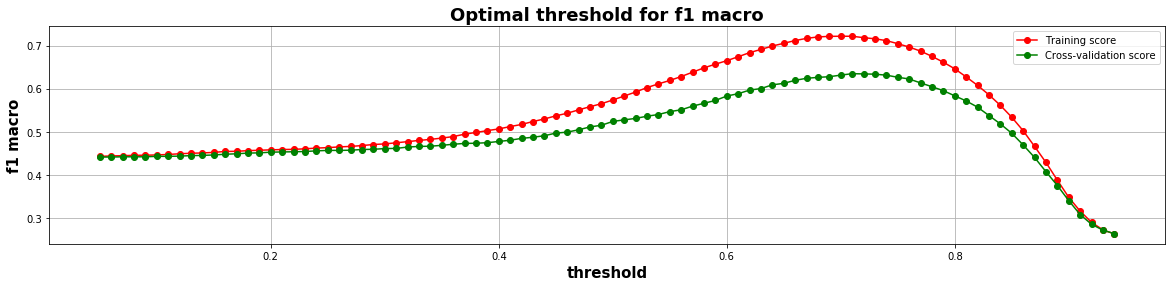

CPU times: user 2.76 s, sys: 55.2 ms, total: 2.81 s
Wall time: 1.32 s


In [222]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = gbm.predict(X_tttrain)
y_prob_val = gbm.predict(X_tttval)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_ttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_ttval, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [215]:
class GBMGridSearch(BaseEstimator, TransformerMixin):
    def __init__(self, cols_cat, param_grid, scoring, cv, verbose, path_model, model_name):
        self.cols_cat = cols_cat
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        self.path_model = path_model
        self.model_name = model_name
        
    def fit(self, X, y):
        self.cv_results_= {}
        self.best_params_ = {}
        splits = []
        for idx_train, idx_test in self.cv.split(X, y):
            splits.append((idx_train, idx_test))
        
        n_splits = self.cv.get_n_splits()
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        params_combinations = list(itertools.product(*(param_values)))
        n_combinations = len(params_combinations)
        
        for i in range(n_splits):
            self.cv_results_['split%d_train_score'%i] = np.zeros(n_combinations)
            self.cv_results_['split%d_test_score'%i] = np.zeros(n_combinations)
        self.cv_results_['mean_train_score'] = np.zeros(n_combinations)
        self.cv_results_['std_train_score'] = np.zeros(n_combinations)
        self.cv_results_['mean_test_score'] = np.zeros(n_combinations)
        self.cv_results_['std_test_score'] = np.zeros(n_combinations)
        self.cv_results_['params'] = []
        
        st_time = time.time()
        self.best_test_score_ = 0
        self.best_params_ = {}
        self.best_estimator_ = {}
        
        param_names = list(self.param_grid.keys())
        param_values = list(self.param_grid.values())
        for j, params in enumerate(params_combinations):
            d_params = {k:v for (k,v) in zip(param_names, params)}
            str_d_params = '; '.join(["%s: %s" % (str(k), str(v)) for k,v in d_params.items()])
            if self.verbose > 0:
                print("[fit %d/%d] %.3g s| params %s"%(j+1, n_combinations, time.time()-st_time, str_d_params))

            scores_train = []
            scores_test = []
            for i, (idx_train, idx_test) in enumerate(splits):
                lgb_train = lgb.Dataset(X.loc[idx_train], y.loc[idx_train], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)
                lgb_test = lgb.Dataset(X.loc[idx_test], y.loc[idx_test], feature_name='auto', categorical_feature=self.cols_cat, free_raw_data=False)

                gbm = lgb.train(d_params,
                                lgb_train,
                                feval=f1_macro_eval,
                                valid_sets=[lgb_test],               
                                valid_names=['test'],
                                verbose_eval=False)

                _, score_train, _ = self.scoring(gbm.predict(X.loc[idx_train]), lgb_train)
                _, score_test, _ = self.scoring(gbm.predict(X.loc[idx_test]), lgb_test)
                scores_train.append(score_train)
                scores_test.append(score_test)
                self.cv_results_['split%d_train_score'%i][j] = score_train
                self.cv_results_['split%d_test_score'%i][j] = score_test
                if self.verbose > 1:
                    print("[cv %d/%d] | train score %.3g ; test score % .3g" % (i+1, n_splits, score_train, score_test))

            if np.mean(scores_test) > self.best_test_score_:
                self.best_test_score_ = np.mean(scores_test)
                self.best_params_ = d_params
                self.best_estimator_ = gbm
                joblib.dump(gbm, os.path.join(self.path_model, '%s_grid.best_estimator.pkl' % self.model_name))
                
            self.cv_results_['mean_train_score'][j] = np.mean(scores_train)
            self.cv_results_['std_train_score'][j] = np.std(scores_train)
            self.cv_results_['mean_test_score'][j] = np.mean(scores_test)
            self.cv_results_['std_test_score'][j] = np.std(scores_test)
            self.cv_results_['params'].append(d_params)
        return self


### GMBGrid

In [223]:
model_type = 'ensemble'
model_name = 'lgboost_2'
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)

# specify your configurations as a dict
param_grid = {'boosting_type': ['gbdt'],
              'objective': ['binary'],
              'metric': ['binary_logloss'],
              'num_leaves': [19, 25, 31, 40],
              'learning_rate': [0.05],
              'feature_fraction': [0.7, 0.8, 0.9],
              'bagging_fraction': [0.7, 0.8, 0.9],
              'bagging_freq': [5],
              'num_boost_round': [400],
              'early_stopping_rounds': [25],
              'verbose': [0]}

gbm_grid = GBMGridSearch(cols_cat=cols_cat, 
                         param_grid=param_grid, 
                         scoring=f1_macro_eval, 
                         cv=strat_cv, 
                         verbose=2,
                         path_model=path_model,
                         model_name=model_name)

warnings.filterwarnings('ignore')
gbm_grid.fit(X_ttrain, y_train)

[fit 1/36] 3.62e-05 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 19; learning_rate: 0.05; feature_fraction: 0.7; bagging_fraction: 0.7; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.67 ; test score  0.626
[cv 2/5] | train score 0.658 ; test score  0.625
[cv 3/5] | train score 0.656 ; test score  0.615
[cv 4/5] | train score 0.642 ; test score  0.611
[cv 5/5] | train score 0.659 ; test score  0.625
[fit 2/36] 7.43 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 19; learning_rate: 0.05; feature_fraction: 0.7; bagging_fraction: 0.8; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.657 ; test score  0.624
[cv 2/5] | train score 0.684 ; test score  0.631
[cv 3/5] | train score 0.656 ; test score  0.611
[cv 4/5] | train score 0.694 ; test score  0.624
[cv 5/5] | train score 0.669 ; test score  0.628
[fit 3/

[cv 2/5] | train score 0.689 ; test score  0.628
[cv 3/5] | train score 0.655 ; test score  0.611
[cv 4/5] | train score 0.68 ; test score  0.623
[cv 5/5] | train score 0.698 ; test score  0.626
[fit 18/36] 142 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 25; learning_rate: 0.05; feature_fraction: 0.9; bagging_fraction: 0.9; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.676 ; test score  0.63
[cv 2/5] | train score 0.676 ; test score  0.629
[cv 3/5] | train score 0.662 ; test score  0.612
[cv 4/5] | train score 0.709 ; test score  0.621
[cv 5/5] | train score 0.69 ; test score  0.624
[fit 19/36] 152 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 31; learning_rate: 0.05; feature_fraction: 0.7; bagging_fraction: 0.7; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.699 ; test score  0.629
[cv 2/5] | tr

[cv 1/5] | train score 0.702 ; test score  0.628
[cv 2/5] | train score 0.674 ; test score  0.626
[cv 3/5] | train score 0.703 ; test score  0.614
[cv 4/5] | train score 0.718 ; test score  0.618
[cv 5/5] | train score 0.705 ; test score  0.629
[fit 35/36] 297 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 40; learning_rate: 0.05; feature_fraction: 0.9; bagging_fraction: 0.8; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] | train score 0.704 ; test score  0.627
[cv 2/5] | train score 0.729 ; test score  0.628
[cv 3/5] | train score 0.718 ; test score  0.617
[cv 4/5] | train score 0.697 ; test score  0.618
[cv 5/5] | train score 0.717 ; test score  0.626
[fit 36/36] 306 s| params boosting_type: gbdt; objective: binary; metric: binary_logloss; num_leaves: 40; learning_rate: 0.05; feature_fraction: 0.9; bagging_fraction: 0.9; bagging_freq: 5; num_boost_round: 400; early_stopping_rounds: 25; verbose: 0
[cv 1/5] |

GBMGridSearch(cols_cat=['amortization', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range', 'gender', 'income type', 'naics code'],
       cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       param_grid={'boosting_type': ['gbdt'], 'objective': ['binary'], 'metric': ['binary_logloss'], 'num_leaves': [19, 25, 31, 40], 'learning_rate': [0.05], 'feature_fraction': [0.7, 0.8, 0.9], 'bagging_fraction': [0.7, 0.8, 0.9], 'bagging_freq': [5], 'num_boost_round': [400], 'early_stopping_rounds': [25], 'verbose': [0]},
       path_model='../trained_models/ensemble',
       scoring=<function f1_macro_eval at 0x1a1f5b08c8>, verbose=2)

In [224]:
gbm_grid.best_params_

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_leaves': 40,
 'learning_rate': 0.05,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'num_boost_round': 400,
 'early_stopping_rounds': 25,
 'verbose': 0}

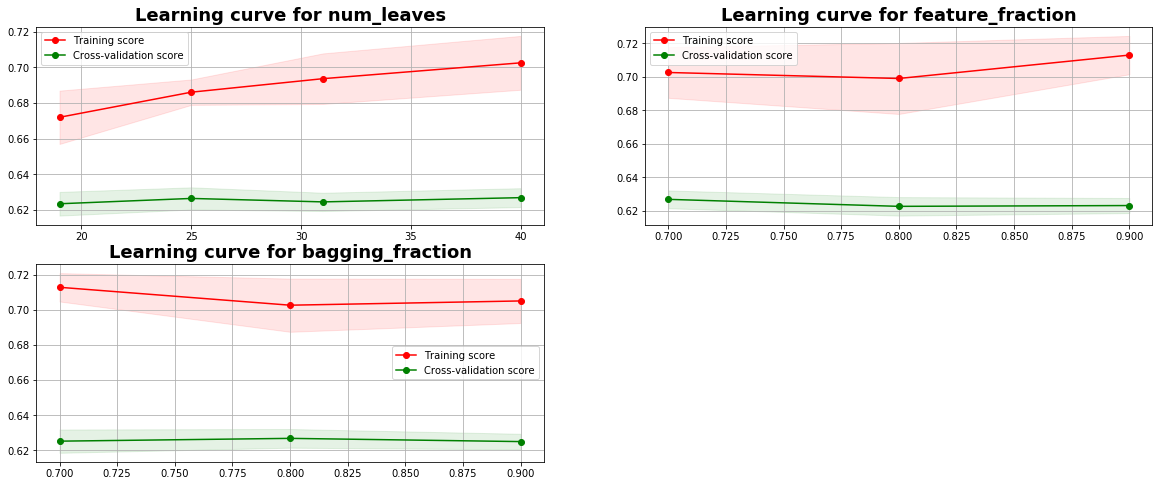

In [227]:
plot_learning_curve(param_grid, gbm_grid.best_params_, gbm_grid.cv_results_, params_logscale=[])

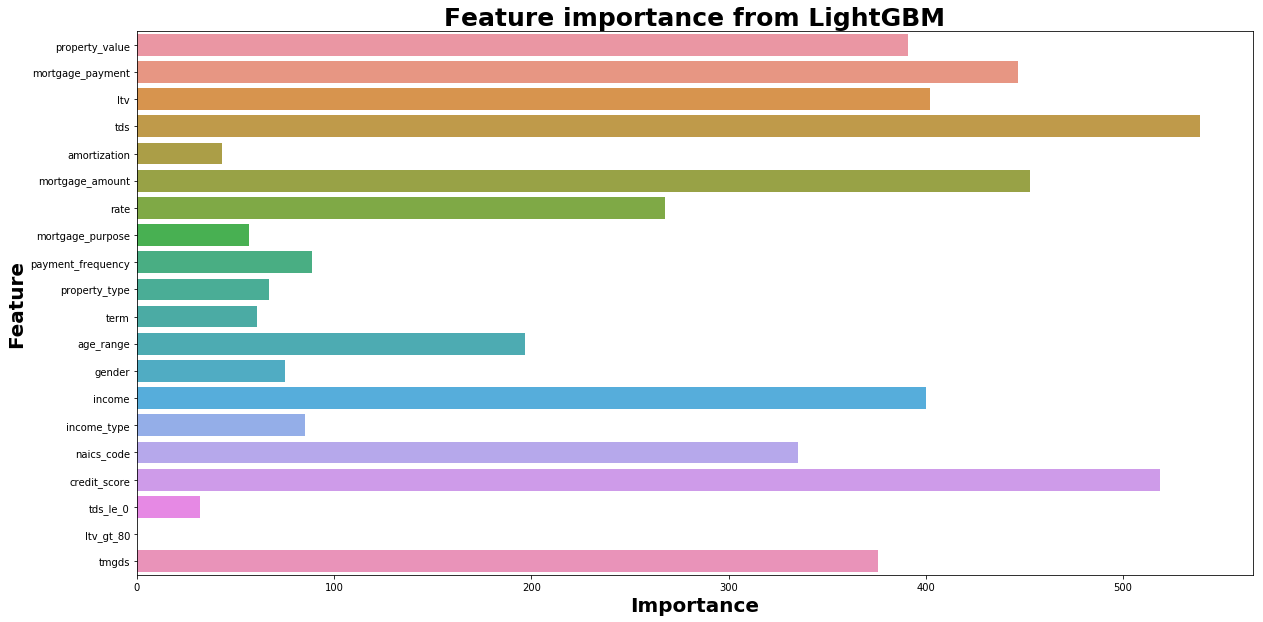

In [228]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

df_feat = pd.DataFrame({'Feature': gbm_grid.best_estimator_.feature_name(), 
                        'Importance': gbm_grid.best_estimator_.feature_importance()})
sns.barplot(x='Importance', y='Feature', data=df_feat, ax=ax)
ax.set_title("Feature importance from LightGBM", fontweight='bold', fontsize=25)
ax.set_xlabel("Importance", fontweight='bold', fontsize=20)
ax.set_ylabel("Feature", fontweight='bold', fontsize=20)
plt.show(fig)

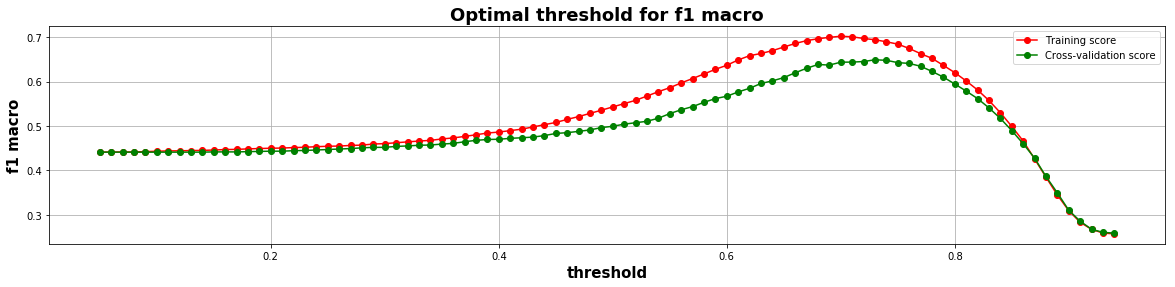

CPU times: user 2.34 s, sys: 39.1 ms, total: 2.38 s
Wall time: 1.05 s


In [229]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = gbm_grid.best_estimator_.predict(X_tttrain)
y_prob_val = gbm_grid.best_estimator_.predict(X_tttval)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_ttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_ttval, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

In [230]:
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

X_test['Result_Predicted'] =  np.where(gbm.predict(X_ttest) > best_th, 1, 0)
X_test['Unique_ID'] = X_test['unique_id']
X_test.loc[:, 'Result_Predicted']  = X_test['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(X_test[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "sub_%s.csv" % model_name), index=False)

del X_test['Unique_ID']
del X_test['Result_Predicted']

# Save the result of the gridsearch
joblib.dump(gbm, os.path.join(path_model, '%s.pkl' % model_name))

['../trained_models/ensemble/lgboost_2.pkl']